In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_catchments(catchments, grid):
    fig, ax = plt.subplots(figsize=(20, 10))

    grid.dissolve().plot(ax=ax, color="lightgray")
    catchments.plot(ax=ax, column="t", legend=True, cmap="cividis_r")

In [3]:
traveltime_cols = [
    'walk_t',
    'bike_s_t',
    'bike_f_t',
    'pt_r_t',
    'pt_m_t',
    'car_r_t',
    'car_m_t',
]


grid_cols = [
    "YKR_ID",
    "geometry",
]

times = [15, 30, 45, 60, 75]


grid = gpd.read_file("./data/grid/")[grid_cols]
grid = grid.to_crs(epsg=4326)

In [4]:
id = grid.sample().iloc[0]["YKR_ID"]
print(id)

5829330


In [5]:
traveltimes = pd.read_csv(
    f"./data/flat_matrix/travel_times_to_ {id}.txt", sep=';', na_values=['-1']
)
interest_col = "pt_m_t"
intrest_times = traveltimes[["from_id", interest_col]]

tt_grid = grid.merge(intrest_times, on=traveltimes["from_id"])
tt_grid = tt_grid[["geometry", interest_col]]

In [6]:
tt_grid['t'] = np.NaN

for time in reversed(times):
    mask = (tt_grid[interest_col] <= time)
    tt_grid.loc[mask, "t"] = time
clean = tt_grid.dropna()

In [7]:
catchments = clean.dissolve("t").reset_index()
catchments = catchments[["geometry", "t"]]

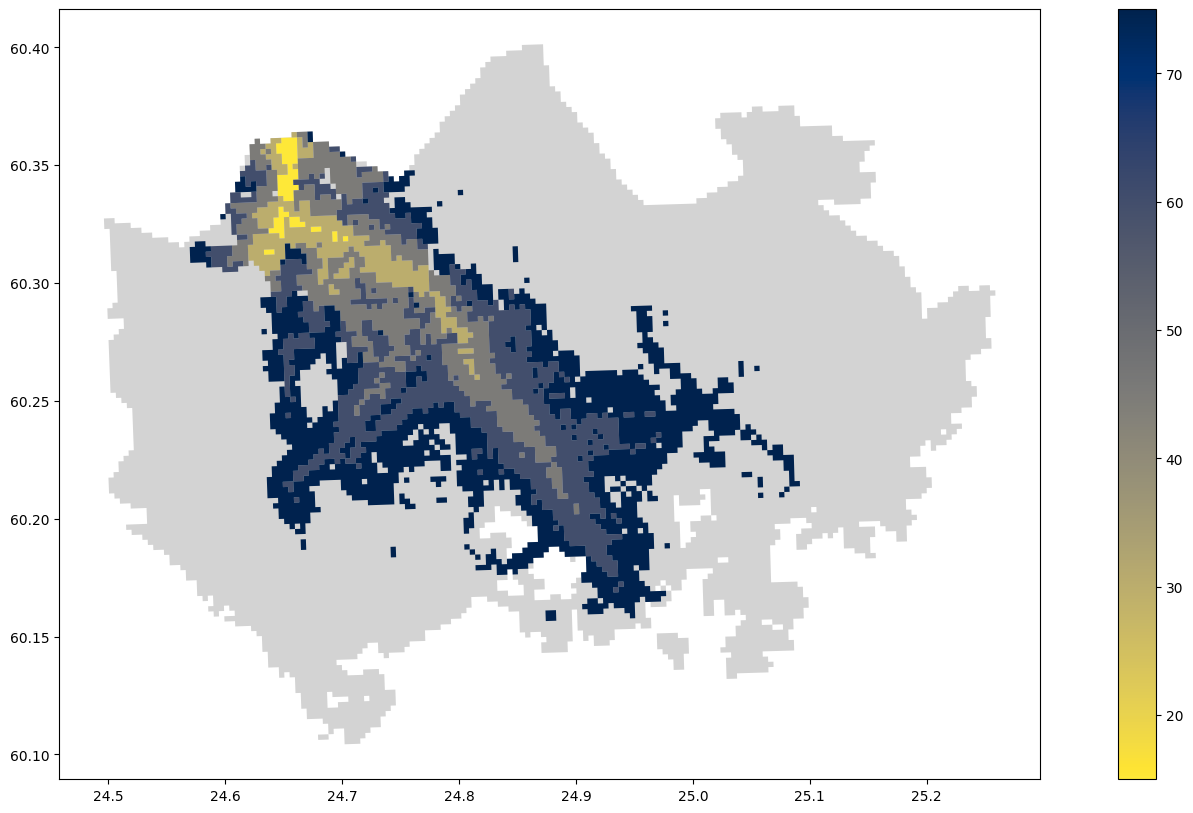

In [8]:
plot_catchments(catchments, grid)

In [9]:
catchments.to_file(f"./data/catchments/{id}_{interest_col}.geojson", driver="GeoJSON")